In [ ]:
!pip install bayesian-optimization

In [ ]:
# Import the libraries necessary for data processing, analysis and visualization:

import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from datetime import datetime
from scipy.stats import chi2, chi2_contingency, ttest_ind, mannwhitneyu
from typing import List, Tuple
import plotly.express as px
from scipy.spatial.distance import cdist

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

import json
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import combinations, chain
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Импортирование необходимых модулей для вычисления VIF (фактор инфляции дисперсии):
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Импортируем типы данных для аннотирования функций:
from typing import List, Tuple

# Импортируем модуль для работы с Google Drive в Google Colab (в случае использования этого окружения):
from google.colab import drive
import missingno as msno
import itertools
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from bayes_opt import BayesianOptimization
from hyperopt import fmin, tpe, hp, Trials




In [ ]:
try:
    import optuna
except:
    !pip install optuna
    import optuna

In [ ]:
# настройка поведения
TARGET_VAR_OUTLIERS_DELETE = True

In [ ]:
# data load
drive.mount(f'/content/drive/', force_remount=False)
path_to_disk = pathlib.Path(f'/content/drive/My Drive/')
df_train = pd.read_csv(path_to_disk / '/content/drive/MyDrive/Colab Notebooks/Boston/train.csv')

Mounted at /content/drive/


# Исследовательский анализ данных

CRIM: Per capita crime rate by town

ZN: Proportion of residential land zoned for lots over 25,000 sq. ft

INDUS: Proportion of non-retail business acres per town

CHAS : Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX: Nitric oxide concentration (parts per 10 million)

RM: Average number of rooms per dwelling

AGE: Proportion of owner-occupied units built prior to 1940

DIS: Weighted distances to five Boston employment centers

RAD: Index of accessibility to radial highways

PTRATIO: Pupil-teacher ratio by town

B: 1000(Bk — 0.63)², where Bk is the proportion of [people of African American descent] by town

LSTAT: Percentage of lower status of the population

__MEDV__: Median value of owner-occupied homes in $1000s

In [ ]:
df_train = df_train.drop('ID', axis=1, inplace=False)
df_train.sample(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
168,0.33983,22.0,5.86,0,0.431,6.108,34.9,8.0555,7,330,19.1,390.18,9.16,24.3
11,1.05393,0.0,8.14,0,0.538,5.935,29.3,4.4986,4,307,21.0,386.85,6.58,23.1
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     333 non-null    float64
 1   zn       333 non-null    float64
 2   indus    333 non-null    float64
 3   chas     333 non-null    int64  
 4   nox      333 non-null    float64
 5   rm       333 non-null    float64
 6   age      333 non-null    float64
 7   dis      333 non-null    float64
 8   rad      333 non-null    int64  
 9   tax      333 non-null    int64  
 10  ptratio  333 non-null    float64
 11  black    333 non-null    float64
 12  lstat    333 non-null    float64
 13  medv     333 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 36.6 KB


All the features have proper numerical types. No types' changes are needed.

In [ ]:
df_train.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,3.360341,10.689189,11.293483,0.060060,0.557144,6.265619,68.226426,3.709934,9.633634,409.279279,18.448048,359.466096,12.515435,22.768769
std,7.352272,22.674762,6.998123,0.237956,0.114955,0.703952,28.133344,1.981123,8.742174,170.841988,2.151821,86.584567,7.067781,9.173468
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,6.000000,1.129600,1.000000,188.000000,12.600000,3.500000,1.730000,5.000000
25%,0.078960,0.000000,5.130000,0.000000,0.453000,5.884000,45.400000,2.122400,4.000000,279.000000,17.400000,376.730000,7.180000,17.400000
50%,0.261690,0.000000,9.900000,0.000000,0.538000,6.202000,76.700000,3.092300,5.000000,330.000000,19.000000,392.050000,10.970000,21.600000
75%,3.678220,12.500000,18.100000,0.000000,0.631000,6.595000,93.800000,5.116700,24.000000,666.000000,20.200000,396.240000,16.420000,25.000000
max,73.534100,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,21.200000,396.900000,37.970000,50.000000


In [ ]:
#пропущенные значение
(df_nan:= df_train.isnull().sum()).loc[df_nan > 0] .sort_values(ascending=False)
#данном датасете нету не одного пропущенного значение

,0


In [ ]:
def plot_histograms_with_intervals(df, target_col='medv', percentiles=(90, 80), reduction_factors=(2, 4)):
    """
    Создает гистограммы для всех столбцов, кроме целевого (target_col),
    а также дополнительные графики с уменьшенными интервалами, если выполняются условия сокращения.

    :param df: DataFrame с данными
    :param target_col: имя целевого столбца, который нужно исключить
    :param percentiles: границы интервалов в процентах, например, (90, 80)
    :param reduction_factors: коэффициенты сокращения интервалов (для условий сокращения)
    """

    # Количество числовых столбцов в датафрейме, за исключением целевого столбца
    num_cols = df.drop(columns=target_col).shape[1]

    # Количество строк для графиков будет равно количеству столбцов
    nrows = num_cols

    # Создаем холст с 3 столбцами и nrows строками для размещения графиков
    fig, axs = plt.subplots(ncols=3, nrows=nrows, figsize=(15, 4 * nrows))

    # Перебираем все столбцы, кроме целевого
    for idx, col in enumerate(df.drop(columns=target_col).columns):
        # Извлекаем данные текущего столбца, исключая пропущенные значения
        data = df[col].dropna()
        # Определяем минимальное и максимальное значение в полном диапазоне данных
        full_min, full_max = data.min(), data.max()

        # Выбираем текущий график из сетки (первая колонка)
        ax = axs[idx, 0] if nrows > 1 else axs[0]
        # Создаем гистограмму полного диапазона значений
        sns.histplot(data, ax=ax, kde=True)
        ax.set_title(col)  # Устанавливаем заголовок с названием столбца

        # Счетчик для отслеживания занятых колонок
        used_columns = 1

        # Перебираем комбинации процентилей и коэффициентов сокращения
        for percentile, reduction_factor in zip(percentiles, reduction_factors):
            # Вычисляем границы интервала на основе заданного процентиля
            p_min, p_max = np.percentile(data, [(100-percentile)/2, 100-(100-percentile)/2])

            # Проверяем условие: полный диапазон данных значительно больше сокращенного интервала
            if (full_max - full_min) >= reduction_factor * (p_max - p_min):
                # Если условие выполняется, добавляем гистограмму для сокращенного интервала
                ax_zoom = axs[idx, used_columns] if nrows > 1 else axs[used_columns]
                sns.histplot(data[(data >= p_min) & (data <= p_max)], ax=ax_zoom, kde=True)
                ax_zoom.set_title(f'{col} ({percentile}% interval)')  # Устанавливаем заголовок
                used_columns += 1  # Увеличиваем счетчик

        # Отключаем неиспользуемые графики в строке, если их меньше 3
        for empty_ax in range(used_columns, 3):
            axs[idx, empty_ax].set_visible(False)

    # Делаем макет более компактным, чтобы графики не накладывались друг на друга
    plt.tight_layout()
    plt.show()
def plot_interactive_histograms(df, target_col='medv'):
    """
    Строит интерактивные и масштабируемые гистограммы с помощью Plotly.

    :param df: DataFrame с данными
    :param target_col: Имя целевого столбца, который нужно игнорировать
    """
    # Перебираем все столбцы, кроме целевого
    for col in df.drop(columns=target_col).columns:
        # Создаем интерактивную гистограмму с дополнительным "ящиком с усами" (boxplot) на полях
        fig = px.histogram(
            df,
            x=col,
            marginal="box",  # Добавляет boxplot рядом с гистограммой
            nbins=50,        # Количество интервалов (бинов) в гистограмме
            title=f'Распределение {col}'  # Заголовок графика
        )
        # Настраиваем внешний вид гистограммы (уменьшаем расстояние между столбцами)
        fig.update_layout(bargap=0.1)
        # Отображаем график
        fig.show()


def plot_variability(df, target_col='medv', percentiles=(60, 70, 80, 90, 100)):
    """
    Строит графики вариативности для каждого столбца в виде сетки с общей шкалой Y.

    :param df: DataFrame с данными
    :param target_col: Имя целевого столбца, который нужно игнорировать
    :param percentiles: Процентильные значения для расчета интервалов вариативности
    """
    # Количество столбцов (без учета целевого)
    num_cols = df.drop(columns=target_col).shape[1]

    # Устанавливаем количество столбцов и строк в сетке графиков
    ncols = 3
    nrows = (num_cols + ncols - 1) // ncols  # Округляем вверх, чтобы хватило строк

    # Создаем фигуру и сетку для графиков
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows), sharey=True)
    axs = axs.flatten()  # Преобразуем сетку осей в одномерный массив для удобного доступа

    # Перебираем все столбцы, кроме целевого
    for idx, col in enumerate(df.drop(columns=target_col).columns):
        # Извлекаем данные текущего столбца, удаляя пропуски
        data = df[col].dropna()
        # Определяем минимальное и максимальное значения данных
        full_min, full_max = data.min(), data.max()
        # Вычисляем полный диапазон данных
        interval_range = full_max - full_min

        # Список для хранения вариативности
        variability = []
        for p in percentiles:
            # Вычисляем границы интервала для текущего процентиля
            p_min, p_max = np.percentile(data, [(100-p)/2, 100-(100-p)/2])
            # Рассчитываем долю интервала относительно полного диапазона
            variability.append((p, (p_max - p_min) / interval_range))

        # Строим график вариативности для текущего столбца
        sns.lineplot(
            x=[v[0] for v in variability],  # Процентильное покрытие
            y=[v[1] for v in variability],  # Доля интервала
            marker='o',
            ax=axs[idx]
        )
        axs[idx].set_title(f'Вариативность {col}')  # Заголовок графика
        axs[idx].set_xlabel('Процентиль покрытия')  # Подпись оси X
        axs[idx].set_ylabel('Доля интервала')  # Подпись оси Y

    # Отключаем лишние оси, если столбцов меньше, чем ячеек в сетке
    for ax in axs[num_cols:]:
        ax.set_visible(False)

    # Оптимизация расстояний между графиками
    plt.tight_layout()
    plt.show()


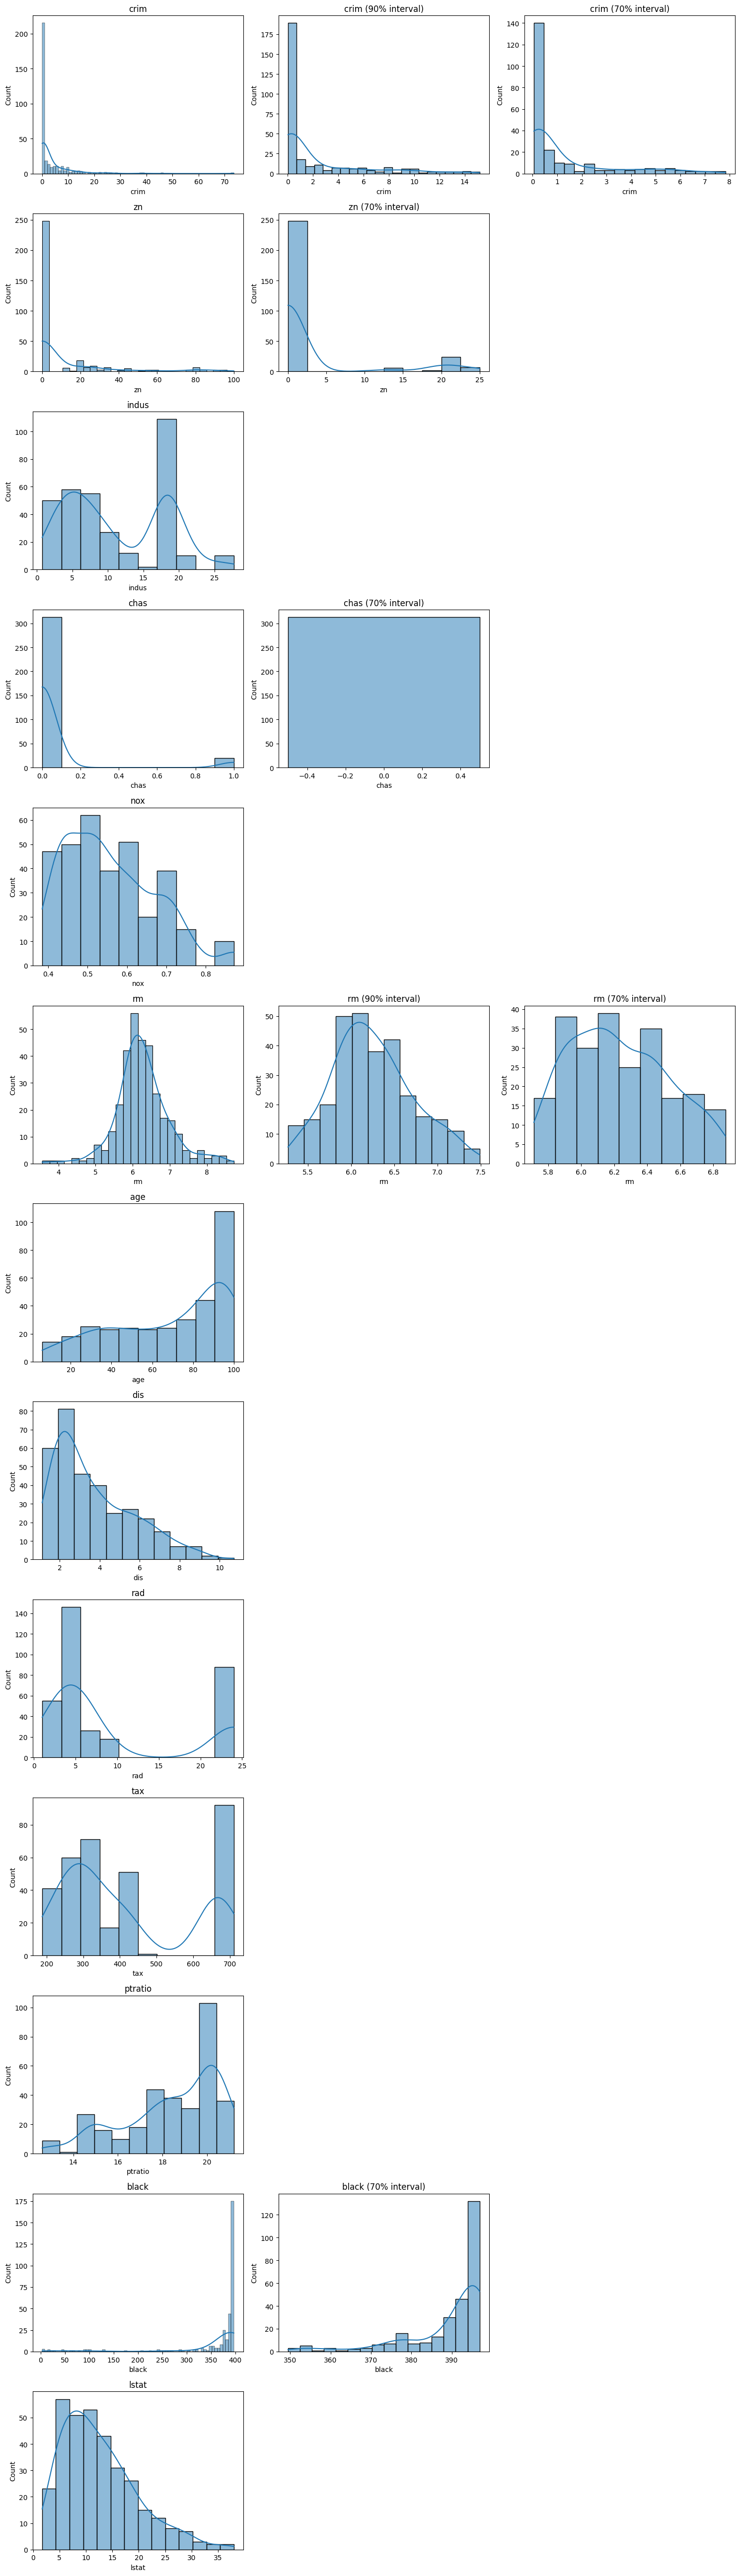

In [ ]:
plot_histograms_with_intervals(df_train, percentiles=(90, 70))

In [ ]:
plot_interactive_histograms(df_train)

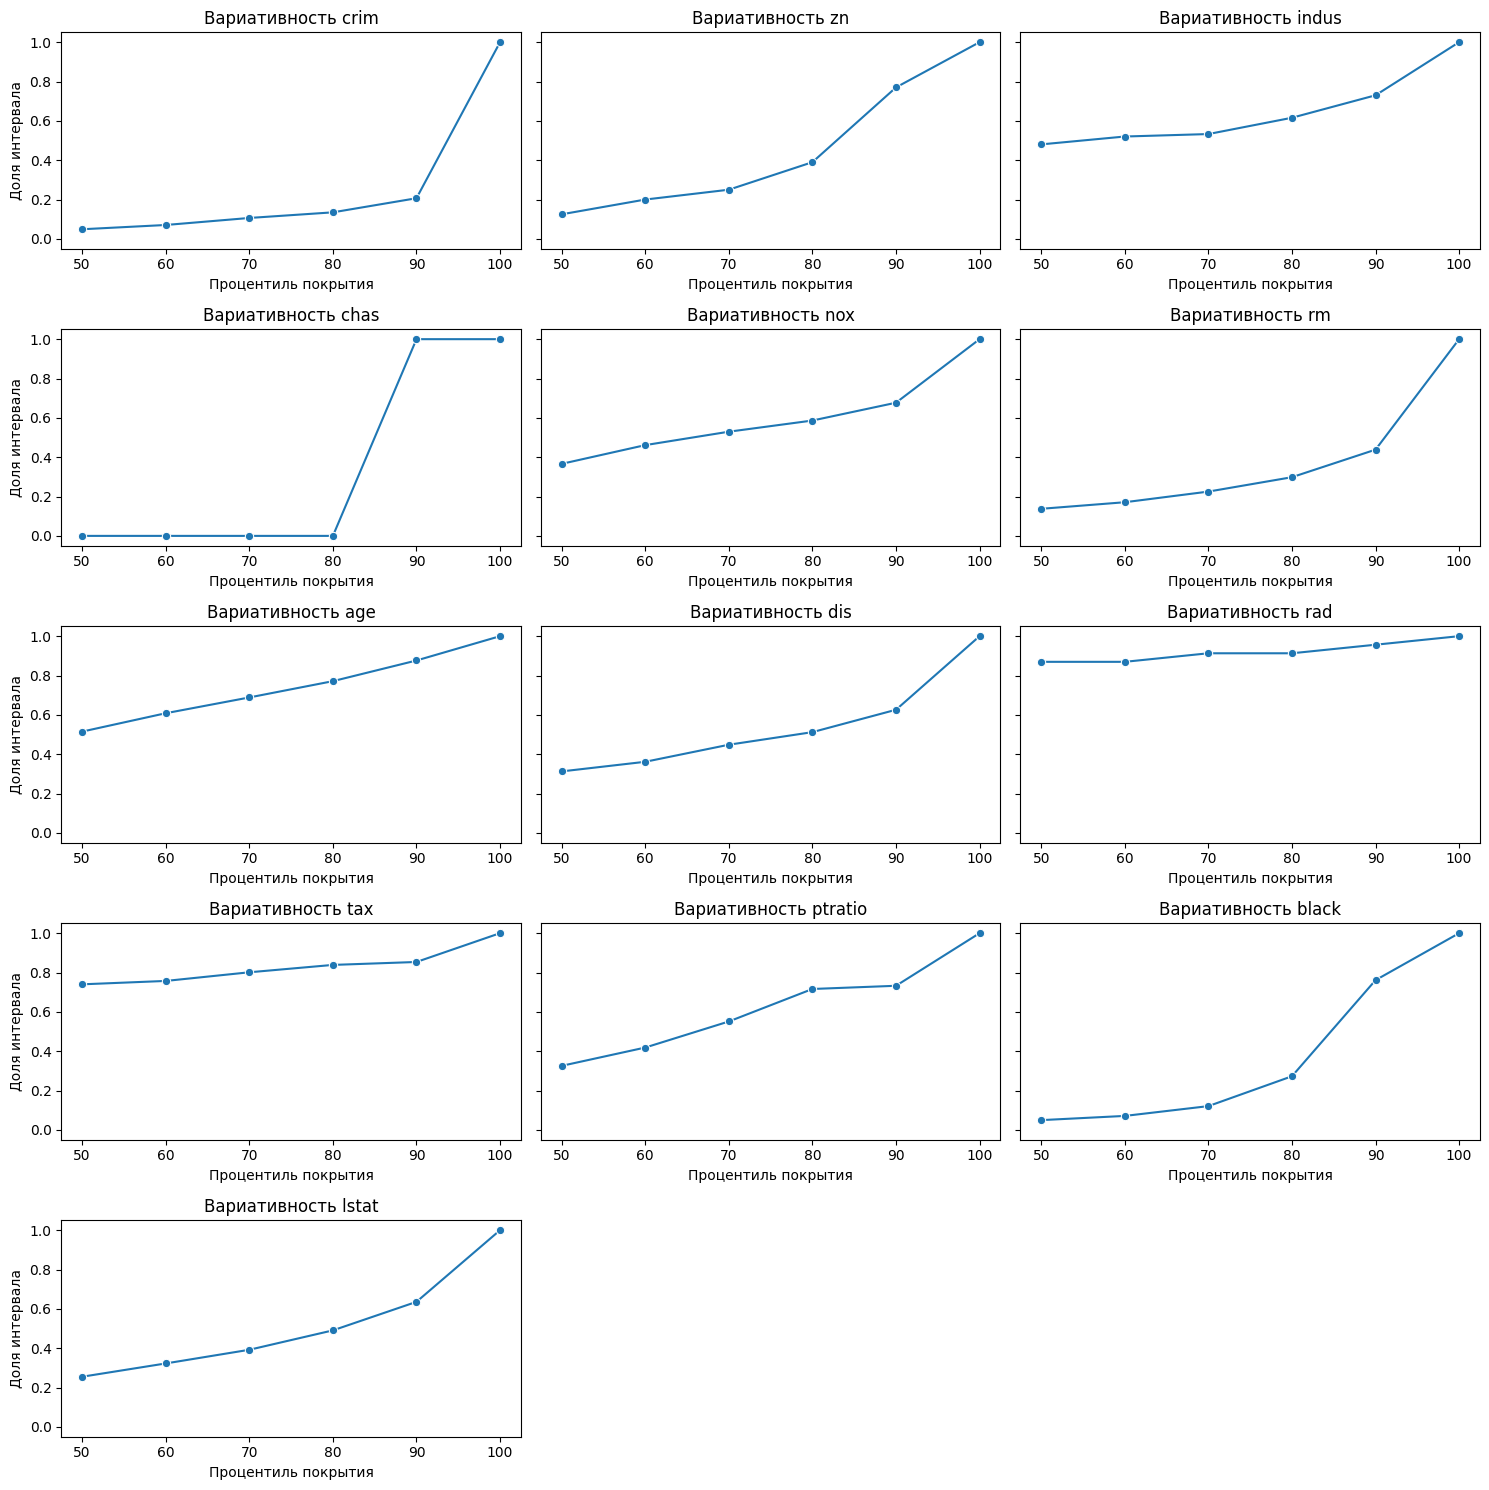

In [ ]:
plot_variability(df_train, percentiles=(50, 60, 70, 80, 90, 100))

### One dimension outliers detection

In [ ]:
def detect_outliers_iqr(df, coef=1.5, target_col='medv'):
    """
    Adds columns to the dataframe labelled discard/not discard for each numeric attribute.

    Parameters:
    - df: pandas.DataFrame - the original dataframe.
    - coef: float - the coefficient for the interquartile range (default is 1.5).

    Returns:
    - pandas.DataFrame - dataframe with added columns of the form ‘<trait name>_outlier’.
    """

    result_df = df.copy()
    result_df.drop(columns=target_col, inplace=True)

    for column in result_df.select_dtypes(include=np.number).columns:
        Q1 = df[column].quantile(0.25)  # First quartile
        Q3 = df[column].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # IQR

        lower_bound = Q1 - coef * IQR
        upper_bound = Q3 + coef * IQR

        result_df[column] = ~df[column].between(lower_bound, upper_bound)

    return result_df

In [ ]:
outliers_df = detect_outliers_iqr(df_train)
outliers_df.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
# количество выбросов для каждого объекта
(df_temp := outliers_df.sum().sort_values(ascending=False) / df_train.shape[0]).loc[df_temp > 0]

,0
black,0.141141
crim,0.126126
zn,0.123123
rm,0.063063
chas,0.060060
ptratio,0.027027
lstat,0.021021
dis,0.003003


In [ ]:
print(f'Строки с выбросами: {((one_dim_outliers := outliers_df.sum(axis=1)).loc[one_dim_outliers > 0].shape[0] / df_train.shape[0] * 100):.1f} %')

Строки с выбросами: 44.1 %


In [ ]:
one_dim_outliers.value_counts()

,count
0,186
1,113
2,29
3,3
4,2


<Axes: >

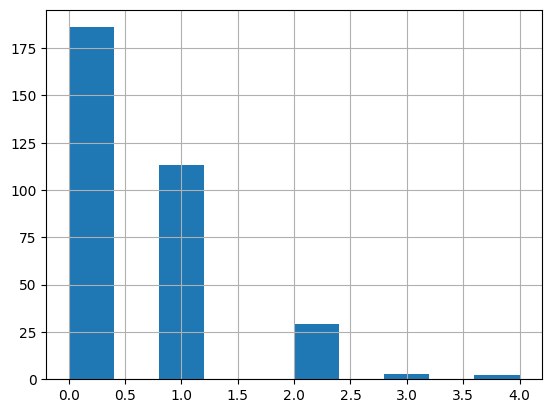

In [ ]:
one_dim_outliers.hist()

### Обнаружение многомерных выбросов

In [ ]:
def detect_multi_outliers(df: pd.DataFrame,
                          distance_type: str = 'mahalanobis',
                          threshold_quantile: float = 0.975,
                          return_distances: bool = False,
                          exclude_columns: list = None) -> tuple:
    """
    Detect outliers in a multivariate dataset using specified distance metrics.

    Parameters:
    ----------
    df : pandas.DataFrame
        DataFrame containing only numerical columns.
    distance_type : str
        Type of distance metric to use ('mahalanobis', 'euclidean', 'cityblock').
    threshold_quantile : float
        Quantile for the chi-square distribution (Mahalanobis) or
        empirical distribution (other distances).
    return_distances : bool
        If True, return distances along with outlier indices.
    exclude_columns : list or None
        List of columns to exclude from outlier detection.

    Returns:
    ----------
    tuple : (outlier_indices, distances) if return_distances=True,
            otherwise (outlier_indices,).
    """
    if exclude_columns is None:
        exclude_columns = []

    # Filter out excluded columns
    df_numeric = df.drop(columns=exclude_columns, errors='ignore')

    # Ensure only numeric columns are used
    df_numeric = df_numeric.select_dtypes(include=np.number)

    # Compute mean of the dataset
    mean = df_numeric.mean()

    if distance_type == 'mahalanobis':
        # Covariance matrix and its inverse
        cov = df_numeric.cov().values
        inv_covmat = np.linalg.inv(cov)

        # Mahalanobis distances
        diff = df_numeric - mean
        distances = np.sqrt(np.einsum('ij,jk,ik->i', diff.values, inv_covmat, diff.values))

        # Threshold based on chi-square distribution
        threshold = chi2.ppf(threshold_quantile, df_numeric.shape[1])

    else:
        # Compute distances using the specified metric
        distances = cdist(df_numeric, [mean], metric=distance_type).ravel()

        # Threshold based on empirical quantile
        threshold = np.quantile(distances, threshold_quantile)

    # Identify outlier indices
    outlier_indices = np.where(distances > threshold)[0]

    if return_distances:
        return outlier_indices, distances
    return (outlier_indices,)

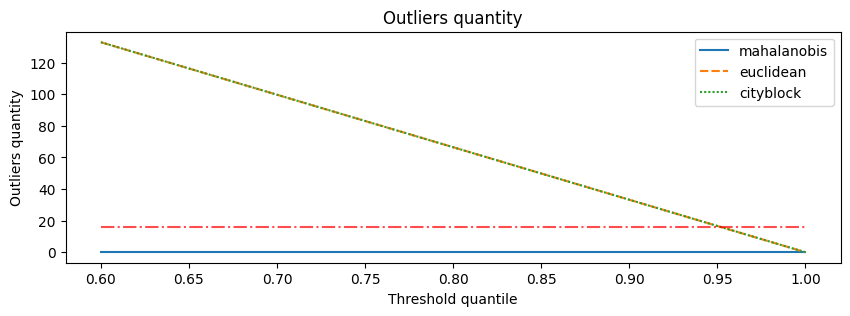

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))

dist_type_outliers = {distance_type: np.vectorize(lambda x: detect_multi_outliers(df_train,
                                                                                  distance_type=distance_type,
                                                                                  threshold_quantile=x,
                                                                                  exclude_columns=['medv'])[0].shape[0])(np.linspace(0.6, 1, 20))
 for distance_type in ['mahalanobis', 'euclidean', 'cityblock']}

sns.lineplot(data=pd.DataFrame(dist_type_outliers, index=np.linspace(0.6, 1, 20)), ax=ax)
sns.lineplot(x=np.linspace(0.6, 1, 20), y=[int(df_train.shape[0] * 0.05)] * 20, ax=ax, linestyle='-.', alpha=0.7, color='red')
ax.set_xlabel('Threshold quantile')
ax.set_ylabel('Outliers quantity')
plt.title('Outliers quantity')
plt.show()

In [ ]:
multi_outliers = detect_multi_outliers(df_train, distance_type='cityblock', threshold_quantile=0.95, exclude_columns=['medv'])
#Этот код используется для обнаружения мультивариативных выбросов в данных.

## Target value

### Outliers

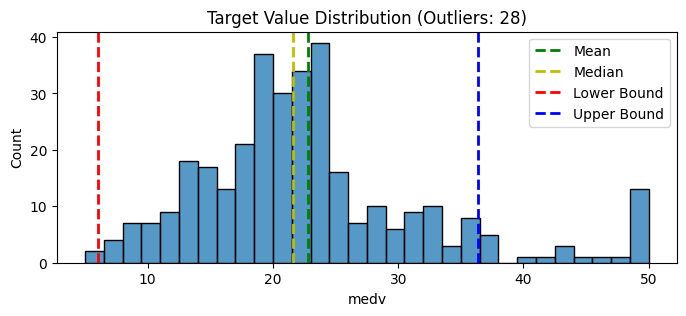

In [ ]:
# Coefficient for the interquartile range (IQR) method
IQR_COEFFICIENT = 1.5

plt.figure(figsize=(8, 3))

# Plot the histogram of the target variable
sns.histplot(df_train['medv'], bins=30)

# Add lines for the mean and median
plt.axvline(df_train['medv'].mean(), color='g', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(df_train['medv'].median(), color='y', linestyle='dashed', linewidth=2, label='Median')

# Calculate IQR and boundaries for outliers
q1 = df_train['medv'].quantile(0.25)  # First quartile (25th percentile)
q3 = df_train['medv'].quantile(0.75)  # Third quartile (75th percentile)
iqr = q3 - q1  # Interquartile range (IQR)
lower_bound_for_target = q1 - IQR_COEFFICIENT * iqr  # Lower bound for outliers
upper_bound_for_target = q3 + IQR_COEFFICIENT * iqr  # Upper bound for outliers

# Count the number of outliers
outliers_count = ((df_train['medv'] < lower_bound_for_target) | (df_train['medv'] > upper_bound_for_target)).sum()

# Add vertical lines for the outlier boundaries
plt.axvline(lower_bound_for_target, color='r', linestyle='dashed', linewidth=2, label='Lower Bound')
plt.axvline(upper_bound_for_target, color='b', linestyle='dashed', linewidth=2, label='Upper Bound')

# Add labels, title, and legend
plt.title(f'Target Value Distribution (Outliers: {outliers_count})')
plt.xlabel('medv')
plt.ylabel('Count')
plt.legend()

# Display the plot
plt.show()

In [ ]:
#df_train = df_train[df_train['medv'].between(lower_bound_for_target, upper_bound_for_target)]

In [ ]:
#sns.histplot(df_train['medv'], bins=30)

### Features influence

In [ ]:
corr_matrix = df_train.corr()
print(corr_series := corr_matrix['medv'].apply(np.abs).sort_values(ascending=False).iloc[1:])

lstat      0.738600
rm         0.689598
ptratio    0.481376
indus      0.473932
tax        0.448078
nox        0.413054
crim       0.407454
age        0.358888
rad        0.352251
zn         0.344842
black      0.336660
dis        0.249422
chas       0.204390
Name: medv, dtype: float64


In [ ]:
CORR_THRESHOLD = 0.3
deletion_variables_via_corr = corr_series.loc[corr_series < CORR_THRESHOLD].index.to_list()
print(deletion_variables_via_corr)

['dis', 'chas']


In [ ]:
def calculate_vif(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the variance inflation factor (VIF) for each feature in a dataframe.

    :param df: Dataframe with numeric attributes
    :return: Dataframe with attributes and their VIF values
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    if df.empty:
        raise ValueError("Input DataFrame is empty")

    # Удаление константных столбцов
    df = df.loc[:, df.nunique() > 1]

    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif_data

In [ ]:
(res_df_train := calculate_vif(df_train.drop(columns='medv')).sort_values('VIF', ascending=False)).loc[res_df_train['VIF'] > 5]

,Feature,VIF
10,ptratio,86.123039
5,rm,83.056962
4,nox,75.640420
9,tax,56.334001
11,black,22.853979
6,age,21.929478
7,dis,15.707447
8,rad,14.649941
2,indus,13.801806
12,lstat,11.341896


In [ ]:
def find_redundant_features(df: pd.DataFrame, target: pd.Series, corr_threshold: float = 0.8):
    """
    Finds feature groups with high mutual correlation and
    returns a dictionary of feature groups with their correlation with the target variable.

    Parameters:
    - df (pd.DataFrame): Dataframe with numeric data (without the target variable).
    - target (pd.Series): The target variable.
    - corr_threshold (float): Threshold for determining high correlation between features (default 0.8).

    Returns:
    - List[dict]: A list of dictionaries where the keys are the trait names and the values are the correlation with the target variable.
    """
    # 1. Добавляем целевую переменную во временный датафрейм
    temp_df = df.copy()
    temp_df['target'] = target

    # 2. Вычисляем корреляционную матрицу
    correlation_matrix = temp_df.corr()

    # 3. Выбираем только сильно коррелирующие признаки
    high_corr_pairs = []
    visited = set()

    for col1, col2 in combinations(df.columns, 2):
        corr_value = abs(correlation_matrix.loc[col1, col2])
        if corr_value >= corr_threshold:
            high_corr_pairs.append((col1, col2))

    # 4. Группируем взаимосвязанные признаки
    feature_groups = []

    for col1, col2 in high_corr_pairs:
        group = {col1, col2}
        merged = False

        for existing_group in feature_groups:
            if not group.isdisjoint(existing_group):
                existing_group.update(group)
                merged = True
                break

        if not merged:
            feature_groups.append(group)

    # 5. Для каждой группы собираем корреляции с целевой переменной
    redundant_features = []

    for group in feature_groups:
        group_corr_with_target = {
            feature: abs(correlation_matrix.loc[feature, 'target']) for feature in group
        }
        redundant_features.append(group_corr_with_target)

    return redundant_features

def find_least_correlated_variable(data: list) -> list:
    """
    Находит ключ с наименьшей корреляцией к целевому значению в каждом словаре списка.

    :param data: Список словарей с переменными и их значениями
    :return: Словарь с ключами и значениями минимальной корреляции
    """
    result = {}
    for item in data:
        min_key = min(item, key=item.get)
        result[min_key] = item[min_key]
    return list(result.keys())

In [ ]:
redundant_by_corr_features_dict = find_redundant_features(df_train.drop(columns='medv'), df_train['medv'])
print(redundant_by_corr_features_dict)
print(redundant_by_corr_features_vars := find_least_correlated_variable(redundant_by_corr_features_dict))

[{'rad': 0.3522508242456341, 'tax': 0.44807769440070433}]
['rad']


## Features and outliers deletion

### Features

In [ ]:
print(f'Redundant features by correlation: {deletion_variables_via_corr}')
print(f'Redundant features by multicolinearity: {redundant_by_corr_features_vars}')

Redundant features by correlation: ['dis', 'chas']
Redundant features by multicolinearity: ['rad']


In [ ]:
def generate_combinations(list1, list2):
    """
    Generates a list of all possible combinations of elements from two lists, including the empty set.

    :param list1: First list
    :param list2: Second list
    :return: List of all combinations
    """
    combined = list1 + list2
    result = [list(combo) for r in range(len(combined) + 1) for combo in itertools.combinations(combined, r)]
    return result

print(features_for_deletion := generate_combinations(deletion_variables_via_corr, redundant_by_corr_features_vars))

[[], ['dis'], ['chas'], ['rad'], ['dis', 'chas'], ['dis', 'rad'], ['chas', 'rad'], ['dis', 'chas', 'rad']]


### Outliers (table for a further use)

In [ ]:
outliers_df['medv'] = df_train['medv'].apply(lambda x: not(lower_bound_for_target <= x <= upper_bound_for_target))
outliers_df['multi'] = outliers_df.index.isin(df_train.iloc[multi_outliers].index)
outliers_df.head(4)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,multi
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Models build

In [ ]:
X, y = StandardScaler().fit_transform(df_train.drop(columns='medv').values), StandardScaler().fit_transform(df_train['medv'].values.reshape(-1, 1)).ravel()

## One level regression models

### Full dataset use

In [ ]:
models = [GradientBoostingRegressor(),
          RandomForestRegressor(),
          LinearRegression(),
          Pipeline([('poly_features', PolynomialFeatures(degree=2)), ('regressor', LinearRegression())]),
          Pipeline([('poly_features', PolynomialFeatures(degree=3)), ('regressor', LinearRegression())]),
          SVR(kernel = 'rbf', gamma = 'scale'),
          Lasso(alpha=0.01),
          Pipeline([('poly', PolynomialFeatures(degree=2)), ('model', Lasso(alpha=0.014, fit_intercept=True, max_iter=4000))]),
          Ridge(alpha=0.01),
          Pipeline([('poly_features', PolynomialFeatures(degree=2)), ('regressor', Ridge(alpha=4, fit_intercept=True))]),
          DecisionTreeRegressor()]

for model in models:
    print(f'{model.__class__.__name__}: R²={cross_val_score(model, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring="r2").mean():.3f}')

GradientBoostingRegressor: R²=0.893
RandomForestRegressor: R²=0.860
LinearRegression: R²=0.688
Pipeline: R²=-0.360
Pipeline: R²=-62.399
SVR: R²=0.748
Lasso: R²=0.691
Pipeline: R²=0.790
Ridge: R²=0.688
Pipeline: R²=0.807
DecisionTreeRegressor: R²=0.643


### Feature reduction

In [ ]:
selected_models = [GradientBoostingRegressor(), RandomForestRegressor()]
results = {model.__class__.__name__: [] for model in selected_models}

for sample in features_for_deletion:
    X_temp = StandardScaler().fit_transform(df_train.drop(columns=sample + ['medv']).values)
    for model in selected_models:
        results[model.__class__.__name__].append(cross_val_score(model, X_temp, y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring="r2").mean())

In [ ]:
features_deletion_results = pd.DataFrame(results, index=[str(features_set) for features_set in features_for_deletion])
features_deletion_results.sort_values(by='GradientBoostingRegressor', ascending=False)

,GradientBoostingRegressor,RandomForestRegressor
"['chas', 'rad']",0.890962,0.861698
[],0.890336,0.860612
['chas'],0.889658,0.858512
['rad'],0.887027,0.862235
"['dis', 'chas']",0.867599,0.825526
['dis'],0.864988,0.816720
"['dis', 'rad']",0.863185,0.821972
"['dis', 'chas', 'rad']",0.861853,0.822454


In [ ]:
df = df_train.drop(columns=['chas', 'rad'])
outliers_df = outliers_df.drop(columns=['chas', 'rad'])

### Outliers delition

In [ ]:
SINGLE_OUTLIERS_THRESHOLD = 2

outliers_df['single'] = outliers_df.drop(columns=['medv', 'multi']).sum(axis=1)
print(f'Unique values for single column: {outliers_df["single"].unique()}')
outliers_df.drop(columns=outliers_df.drop(columns=['single', 'medv', 'multi']).columns, inplace=True)
outliers_df['single'] = outliers_df['single'] >= SINGLE_OUTLIERS_THRESHOLD

outliers_df.head(4)

Unique values for single column: [0 1 2 3 4]


,medv,multi,single
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False


In [ ]:
all_conditions_combinations = list(chain.from_iterable(combinations(outliers_df.columns.to_list(), r) for r in range(1, len(outliers_df.columns.to_list()) + 1)))
all_conditions_combinations

[('medv',),
 ('multi',),
 ('single',),
 ('medv', 'multi'),
 ('medv', 'single'),
 ('multi', 'single'),
 ('medv', 'multi', 'single')]

In [ ]:
outliers_indexes = [(conditions, outliers_df.loc[outliers_df[list(conditions)].all(axis=1)].index.to_list()) for conditions in all_conditions_combinations]

In [ ]:
results_outliers = {model.__class__.__name__: [] for model in selected_models}
outliers_indexes = list(filter(lambda x: len(x[1]) > 0, outliers_indexes))

for condition, indexes in outliers_indexes:
    X_temp = StandardScaler().fit_transform(df.drop(index=indexes, axis=0).drop(columns='medv').values)
    y_temp = StandardScaler().fit_transform(df.drop(index=indexes, axis=0)['medv'].values.reshape(-1, 1)).ravel()
    for model in selected_models:
        results_outliers[model.__class__.__name__].append(cross_val_score(model, X_temp, y_temp, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring="r2").mean())

outliers_deletion_results = pd.DataFrame(results_outliers, index=[str(outliers_indexes_set[0]) for outliers_indexes_set in outliers_indexes])
outliers_deletion_results.sort_values(by='GradientBoostingRegressor', ascending=False)

,GradientBoostingRegressor,RandomForestRegressor
"('medv', 'single')",0.853985,0.825796
"('multi', 'single')",0.835330,0.806836
"('medv',)",0.830514,0.801107
"('multi',)",0.826387,0.815123
"('single',)",0.807352,0.785001


### Model tune

In [ ]:
def objective(trial):
    # Гиперпараметры для оптимизации
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 6),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
    }

    # Создание модели
    model = GradientBoostingRegressor(**params, random_state=42)

    # Настройка кросс-валидации
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Кросс-валидация
    scores = cross_val_score(model, X, y, scoring="r2", cv=kfold, n_jobs=-1)
    return np.mean(scores)  # Оптимизация R²

# Создание Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=-1)



# RandomizedSearchCV
param_dist = {
    "n_estimators": randint(100, 500),
    "learning_rate": uniform(0.01, 0.04),
    "max_depth": randint(3, 10),
    "min_samples_split": randint(2, 6),
    "min_samples_leaf": randint(2, 6),
    "subsample": uniform(0.7, 0.3),
}

# Определение модели
model = GradientBoostingRegressor(random_state=42)

# Настройка кросс-валидации
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist,
    n_iter=50, scoring="r2", cv=kfold,
    random_state=42, n_jobs=-1
)

# Запуск RandomizedSearchCV
random_search.fit(X, y)


[I 2025-02-14 10:27:38,484] A new study created in memory with name: no-name-1b7c12de-4b33-41d4-9a9f-984cf0d563c5
[I 2025-02-14 10:27:46,180] Trial 1 finished with value: 0.8399424595312098 and parameters: {'n_estimators': 184, 'learning_rate': 0.012069752557415719, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.8382701324556557}. Best is trial 1 with value: 0.8399424595312098.
[I 2025-02-14 10:27:46,823] Trial 0 finished with value: 0.8824466505264624 and parameters: {'n_estimators': 383, 'learning_rate': 0.04239355130508588, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 6, 'subsample': 0.8162653073885058}. Best is trial 0 with value: 0.8824466505264624.
[I 2025-02-14 10:27:53,505] Trial 2 finished with value: 0.8760775919981985 and parameters: {'n_estimators': 467, 'learning_rate': 0.0397035616000957, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.7727876500184119}. Best is trial 0 with value: 0.882446650526

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a8f6c463e50>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a8f6c16ee50>,
                                        'mi..._discrete_frozen object at 0x7a8f6b000d90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a8f6c1c7f50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a8f6c4a2150>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a8f6b002590>},
                   random_state=42, scoring='r2')

In [ ]:
# Определение пространства гиперпараметров
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.05),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 6, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 6, 1),
    'subsample': hp.uniform('subsample', 0.7, 1.0)
}

# Определение целевой функции
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])

    model = GradientBoostingRegressor(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        subsample=params['subsample'],
        random_state=42
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, scoring="r2", cv=kfold, n_jobs=-1)
    return -np.mean(scores)

# Инициализация Trials для записи процесса оптимизации
trials = Trials()

# Запуск поиска гиперпараметров
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials

)

100%|██████████| 50/50 [02:25<00:00,  2.91s/trial, best loss: -0.9005266686929158]


In [ ]:

# Вывод лучших параметров
print("Лучшие параметры Optuna:", study.best_params)
print("Лучший R² Optuna:", study.best_value)

# Вывод лучших параметров
print("Лучшие параметры RandomizedSearchCV:", random_search.best_params_)
print("Лучший R² RandomizedSearchCV:", random_search.best_score_)

print("Лучшие параметры:", best)
print("Лучший R²:", -objective(best))

Лучшие параметры Optuna: {'n_estimators': 268, 'learning_rate': 0.04997566953487918, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.9869504720736109}
Лучший R² Optuna: 0.9010424511562455
Лучшие параметры RandomizedSearchCV: {'learning_rate': 0.030665435650840574, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 403, 'subsample': 0.989625805386638}
Лучший R² RandomizedSearchCV: 0.8972093150780154
Лучшие параметры: {'learning_rate': 0.027952554854050356, 'max_depth': 4.0, 'min_samples_leaf': 3.0, 'min_samples_split': 2.0, 'n_estimators': 367.0, 'subsample': 0.8144999304379772}
Лучший R²: 0.9005266686929158


In [ ]:
best_params = study.best_params
best_params['random_state'] = 42

# Обучение и оценка модели с лучшими параметрами
best_model = GradientBoostingRegressor(**best_params)

# Используем KFold для кросс-валидации
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Оцениваем качество модели с помощью cross_val_score
scores = cross_val_score(best_model, X, y, scoring="r2", cv=kfold)
print(f'R² = {scores.mean():.3f}')

R² = 0.901


## Stacking

In [ ]:
# Определение функции для Optuna
def objective_rf(trial):
    # Гиперпараметры для оптимизации с использованием Optuna
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 8),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_float("max_features", 0.5, 1.0)
    }

    # Создаем модель с текущими гиперпараметрами
    model = RandomForestRegressor(**params, random_state=42)

    # Используем KFold для кросс-валидации
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Оцениваем качество модели с помощью cross_val_score
    scores = cross_val_score(model, X, y, scoring="r2", cv=kfold)
    return scores.mean()  # Максимизируем R²

# Создание Optuna study
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=50, n_jobs=-1)


# Определение диапазонов гиперпараметров для RandomizedSearchCV
param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(2, 20),
    "min_samples_split": randint(2, 8),
    "min_samples_leaf": randint(1, 10),
    "max_features": uniform(0.5, 0.5)  # (min, range), т.е. от 0.5 до 1.0
}

# Определение модели
model = RandomForestRegressor(random_state=42)

# Настройка кросс-валидации
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Запуск RandomizedSearchCV
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist,
    n_iter=50, scoring="r2", cv=kfold,
    random_state=42, n_jobs=-1
)

# Запуск RandomizedSearchCV
random_search.fit(X, y)

[I 2025-02-14 10:34:24,054] A new study created in memory with name: no-name-51e72e78-6c10-4d92-bde6-a687fe3798f3
[I 2025-02-14 10:34:28,615] Trial 1 finished with value: 0.7446037326972116 and parameters: {'n_estimators': 207, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 0.8805480004342033}. Best is trial 1 with value: 0.7446037326972116.
[I 2025-02-14 10:34:30,492] Trial 0 finished with value: 0.840361949114571 and parameters: {'n_estimators': 240, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.9731691655789194}. Best is trial 0 with value: 0.840361949114571.
[I 2025-02-14 10:34:35,968] Trial 2 finished with value: 0.7087167210879366 and parameters: {'n_estimators': 495, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5171901013695401}. Best is trial 0 with value: 0.840361949114571.
[I 2025-02-14 10:34:36,424] Trial 3 finished with value: 0.8006262845471477 and parameters: {'n_estima

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a8f6b041790>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a8f6a6f2410>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a8f6a6f08d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a8f6a6f3c90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a8f6c1f3950>},
                   random_state=42, scoring='r2')

In [ ]:
# Вывод лучших параметров
print("Лучшие параметры Optuna:", study_rf.best_params)
print("Лучший R² Optuna:", study_rf.best_value)

# Вывод лучших параметров
print("Лучшие параметры RandomizedSearchCV:", random_search.best_params_)
print("Лучший R² RandomizedSearchCV:", random_search.best_score_)


Лучшие параметры Optuna: {'n_estimators': 124, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.9344419724026118}
Лучший R² Optuna: 0.8656529005269207
Лучшие параметры RandomizedSearchCV: {'max_depth': 10, 'max_features': 0.7019180855290204, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 151}
Лучший R² RandomizedSearchCV: 0.8636257847035527


In [ ]:
best_params_rf = study_rf.best_params
best_params_rf['random_state'] = 42
best_model_rf = RandomForestRegressor(**best_params_rf)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model_rf, X, y, scoring="r2", cv=kfold)
print(f'R² = {scores.mean():.3f}')

R² = 0.866


In [ ]:
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])

In [ ]:
def objective_mlp(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 6),
    }
    model_ds = DecisionTreeRegressor(**params, random_state=42)

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model_ds, X, y, scoring="r2", cv=kfold)
    return scores.mean()

study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(objective_mlp, n_trials=50, n_jobs=-1)

[I 2025-02-14 10:38:43,890] A new study created in memory with name: no-name-4ee983a9-feb3-4a4d-8208-f757a0c7dcab
[I 2025-02-14 10:38:43,942] Trial 0 finished with value: 0.7850502678957548 and parameters: {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7850502678957548.
[I 2025-02-14 10:38:43,949] Trial 1 finished with value: 0.7297324082387218 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7850502678957548.
[I 2025-02-14 10:38:43,990] Trial 2 finished with value: 0.7564352515163204 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7850502678957548.
[I 2025-02-14 10:38:43,992] Trial 3 finished with value: 0.7846145923821102 and parameters: {'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7850502678957548.
[I 2025-02-14 10:38:44,041] Trial 5 finished with value: 0.7166963

In [ ]:
print("Лучшие параметры Optuna:", study_mlp.best_params)
print("Лучший R² Optuna:", study_mlp.best_value)

Лучшие параметры Optuna: {'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6}
Лучший R² Optuna: 0.7889870246805465


In [ ]:
# Определение базовых моделей
gradient_boosting = GradientBoostingRegressor(**best_params)
random_forest = RandomForestRegressor(**best_params_rf)
decisiontree_regressor = DecisionTreeRegressor(**study_mlp.best_params)

# Определение мета-модели
meta_model = MLPRegressor(random_state=42)

# Создание ансамблевой модели через Stacking
stacking_regressor = StackingRegressor(
    estimators=[
        ('gb', gradient_boosting),
        ('rf', random_forest),
        ('mlp', decisiontree_regressor)
    ],
    final_estimator=meta_model
)

# Используем KFold для кросс-валидации
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Оцениваем качество модели с помощью cross_val_score
scores = cross_val_score(stacking_regressor, X, y, scoring="r2", cv=kfold)
print(f'R² = {scores.mean():.3f}')

R² = 0.886


In [ ]:
# Список моделей
models_list = [gradient_boosting, random_forest, stacking_regressor]
model_names = ['GradientBoostingRegressor', 'RandomForestRegressor','StackingRegressor']

# Вычисление MSE для каждой модели
mse_scores = [
    -cross_val_score(model, X, y, scoring="neg_mean_squared_error",
                     cv=KFold(n_splits=5, shuffle=True, random_state=42)).mean()
    for model in models_list
]
# Вычисление MAE для каждой модели
mae_scores = [ -cross_val_score(model, X, y, scoring="neg_mean_absolute_error",
                     cv=KFold(n_splits=5, shuffle=True, random_state=42)).mean()
    for model in models_list
]
#Вычисление MRSE для каждой модели
mrse_scores = [np.sqrt(score) for score in mse_scores]
# Создание DataFrame с результатами
models = pd.DataFrame({
    'Model': model_names,
    'R²': [cross_val_score(model, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring="r2").mean() for model in models_list],
    'MSE': mse_scores,
    'MAE': mae_scores,
    'MRSE': mrse_scores,
})


print(models)

                       Model        R²       MSE       MAE      MRSE
0  GradientBoostingRegressor  0.901042  0.093754  0.225038  0.306192
1      RandomForestRegressor  0.865653  0.129881  0.252672  0.360390
2          StackingRegressor  0.886276  0.106056  0.234402  0.325662


GradientBoostingRegressor является наиболее подходящей моделью для данной задачи, так как она показывает наилучшие результаты по всем основным метрикам.

Для улучшения качества можно:

Подобрать гиперпараметры для Gradient Boosting.
Изучить, какие наблюдения предсказываются с наибольшими ошибками, и попробовать переработать эти данные (удалить выбросы, добавить новые признаки и т.д.).